In [1]:
import numpy as np
import argparse
import cv2 as cv
from collections import Counter
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# this function adds white borders to the images to avoid cropping text in the final step 
def adding_borders(image,size):
    color = [255, 255, 255]
    top, bottom, left, right = [size]*4
    image_with_border = cv.copyMakeBorder(image, top, bottom, left, right, cv.BORDER_CONSTANT, value=color)
    
    return image_with_border

In [3]:
def deskew(image ,show_images=False):
    # function takes in skewed line image and return deskewed image line 
    
    img = image.copy()

    # first step is to detect edges in the rgb image then create lines 

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray,50,150,apertureSize = 3)
    # detecting lines through HLP algorithm 
    
    lines = cv.HoughLinesP(edges,10,np.pi/180,100,minLineLength=50,maxLineGap=50)
    for line in lines:
        x1,y1,x2,y2 = line[0]
        cv.line(img,(x1,y1),(x2,y2),(0,255,0),2)
        
    # second step clustering lines with the same slope together 
        
    def true_line_slope(lines):
        # this function clusters the slopes together then identifies the cluster of the hieghet number of lines

        slopes = [(l[0][3]-l[0][1])/(l[0][2]-l[0][0])for l in lines if l[0][0]!=l[0][2]]

        rounded = [round(k,2) for k in slopes]

        h = Counter(rounded)

        return max(h, key=h.get)
    
    sl=true_line_slope(lines)
    
    #third step detect skew angle
    
    angle = (np.rad2deg(np.arctan(sl)))
    
    # forth step deskew image with the skew angle value
    
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv.warpAffine(image, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
    if show_images==True:
        plt.imshow(image)
        plt.figure()
        plt.imshow(rotated) 
        
    return rotated

In [4]:
# correction of the very thin fonts

def thick_font(image):
    import numpy as np
    image = cv.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv.dilate(image, kernel, iterations=1)
    image = cv.bitwise_not(image)
    return (image)

In [5]:
# remove noisy dots if found
def noise_removal(image):
    kernel = np.ones((1, 1), np.uint8)
    image = cv.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv.erode(image, kernel, iterations=1)
    image = cv.morphologyEx(image, cv.MORPH_CLOSE, kernel)
    image = cv.medianBlur(image, 3)
    return (image)

In [6]:
#removal of extra space 

def remove_extra_info(img):
    
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = 255*(gray < 128).astype(np.uint8) # To invert the text to white
    coords = cv.findNonZero(gray) # Find all non-zero points (text)
    x, y, w, h = cv.boundingRect(coords) # Find minimum spanning bounding box
    rect = img[y:y+h, x:x+w]
    return rect

In [7]:
#resizing using aspect ratio

def image_resize(image, width = None, height = None, inter = cv.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

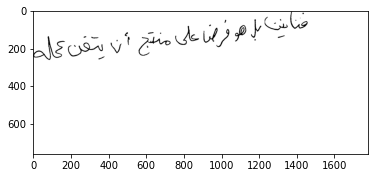

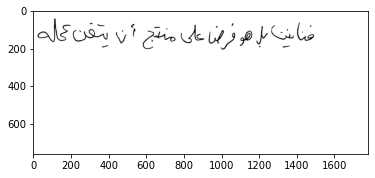

In [8]:
image = cv.imread("test5.tif")
r = deskew(image,show_images=True)

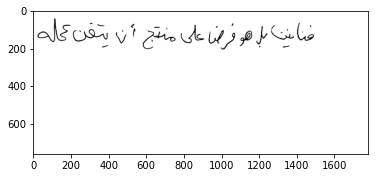

In [9]:
no_noise = noise_removal(r)
plt.imshow(no_noise)

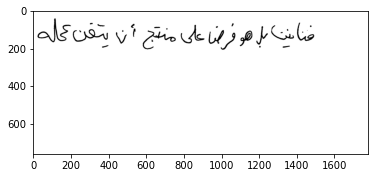

In [10]:
thick_image = thick_font(no_noise)
plt.imshow(thick_image)

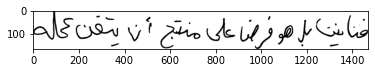

In [11]:
no_borders = remove_extra_info(thick_image)
plt.imshow(no_borders)

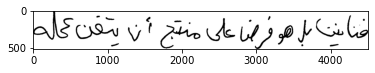

In [12]:
resized = image_resize(no_borders,width= None , height = 512)
plt.imshow(resized)

In [13]:
#!mkdir Processed_Images


In [14]:
in_ = "AugmentedImages/"
out_ = "Processed_Images/"

def preprocess(Path,in_,out_):
    
    pt_in = in_ + Path
    image = cv.imread(pt_in)
    new_borders = adding_borders(image,200)
    r = deskew(new_borders)
    no_noise = noise_removal(r)
    thick_image = thick_font(no_noise)
    no_borders = remove_extra_info(thick_image)
    resized = image_resize(no_borders,width= None , height = 46)
    
    pt_out = out_+ Path
    cv.imwrite(pt_out, resized)




In [15]:
def preprocess_to_memory(Path):
    
    
    image = cv.imread(Path)
    new_borders = adding_borders(image,200)
    r = deskew(new_borders)
    no_noise = noise_removal(r)
    thick_image = thick_font(no_noise)
    no_borders = remove_extra_info(thick_image)
    resized = image_resize(no_borders,width= None , height = 46)
    
    return resized

In [16]:
# In this part I pre-processed all the augmented images and saved them to the disk 
# I will need to re run this notebook to use preprocess_to_memory when prediction form the OCR Modeling nootbook
# That's why I commented this part so as not to be re-run again

# list_paths = os.listdir("AugmentedImages")
# for i in list_paths:
#     preprocess(i,in_,out_)

In [17]:
# # processing the test files 
# test_set = pd.read_csv('TestLabels.csv').drop(['Unnamed: 0'],axis=1).sort_values(by=['Image'])
# test_list = [k.replace('tif','png') for k in list(test_set['Image'])]
# os.makedirs('Processed_Test_Images', exist_ok=True)
# in_ = 'Line Images/'
# out_ = 'Processed_Test_Images/'
# for k in test_list:
#     preprocess(k,in_,out_)
